In [383]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import trange


from torch.autograd import Variable

from IPython.display import Image
from IPython.core.display import HTML 

(70000, 28, 28)


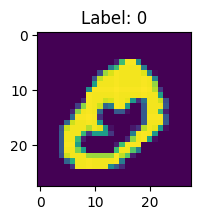

In [384]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

X = np.concatenate([X_train, X_test], axis = 0) / 255.0
X = (X-0.5)/0.5
plt.figure(figsize=(2,2))
plt.imshow(X[63])
plt.title(f"Label: {Y_train[63]}")
print(X.shape)

In [385]:
class Dicriminator(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.l1 = nn.Linear(28*28, 256)
    self.l2 = nn.Linear(256, 256)
    self.l3 = nn.Linear(256, 1)
    self.act = nn.LeakyReLU(0.2)
  
  def forward(self, x):
    x = x.view(-1, 28*28).float()
    x = self.act(self.l1(x))
    x = self.act(self.l2(x))
    x = self.l3(x)
    return nn.Sigmoid()(x)

class Generator(nn.Module):
  def __init__(self, input_features):
    super().__init__()
    self.l1 = nn.Linear(input_features, 256)  
    self.l2 = nn.Linear(256, 256)
    self.l3 = nn.Linear(256, 28*28)
    self.act = nn.ReLU()
  
  def forward(self, x):
    x = self.act(self.l1(x))
    x = self.act(self.l2(x))
    x = self.l3(x)
    x = x.reshape(-1, 1, 28, 28)
    return nn.Tanh()(x)
    


In [386]:
# Dicriminator
Image(url= "https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg")

In [387]:
# Generator
Image(url='https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg')

In [388]:
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
assert X.shape == (70000, 28, 28)

D_model = Dicriminator()
G_model = Generator(128)
d_optim = torch.optim.Adam(D_model.parameters(), lr=0.0002)
g_optim = torch.optim.Adam(G_model.parameters(), lr=0.0002)
loss_fn = torch.nn.BCELoss()
epochs = 500
batch_size = 64
g_losses, d_losses = [], []

for t in (bar := trange(epochs)):
  for idx in range(0, int(X.shape[0]/batch_size)):
    idx+=1
    #Discriminator train
    samples = np.random.randint(0, X.shape[0], batch_size)
    real_input = torch.tensor(X[samples])
    real_out = D_model(real_input)
    real_labels = torch.ones(real_input.shape[0], 1)
    Z = (torch.rand(real_input.shape[0], 128) - 0.5) / 0.5
    fake_input = G_model(Z) # to get noise inputs to discriminator
    fake_out = D_model(fake_input)
    fake_labels = torch.zeros(fake_input.shape[0], 1)
    target = torch.cat((real_labels, fake_labels), 0)
    out = torch.cat((real_out, fake_out), 0)
    d_loss = loss_fn(out, target)
    d_optim.zero_grad()
    d_loss.backward()
    d_optim.step()

    #Generator train
    fake_input = G_model(Z)
    fake_out = D_model(fake_input)
    fake_target = torch.ones([fake_input.shape[0], 1])
    g_loss = loss_fn(fake_out, fake_target)
    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()
    
    g_losses.append(g_loss.item()), d_losses.append(d_loss.item())
    bar.set_description(f"Epochs {t}, Iteration: {idx}, D_loss: {d_loss.item():.3f}, G_loss: {g_loss.item():.3f}")

  #save result images
  # if (t+1) % 20 == 0:
  #   with torch.no_grad():
  #     save_image(fake_input.data, f'fake_images-{t}.png')



Epochs 499, Iteration: 1093, D_loss: 0.422, G_loss: 1.571: 100%|██████████| 500/500 [1:25:11<00:00, 10.22s/it]    


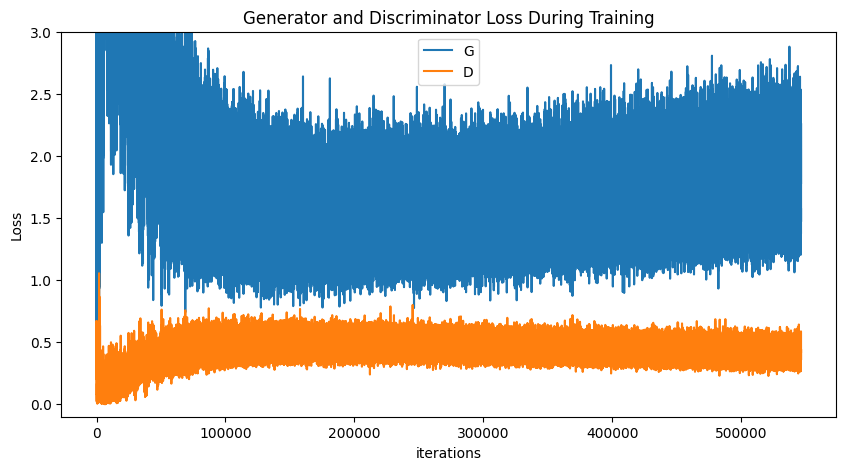

In [389]:
plt.figure(figsize=(10,5))
plt.ylim(-0.1,3)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label='G')
plt.plot(d_losses, label='D')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

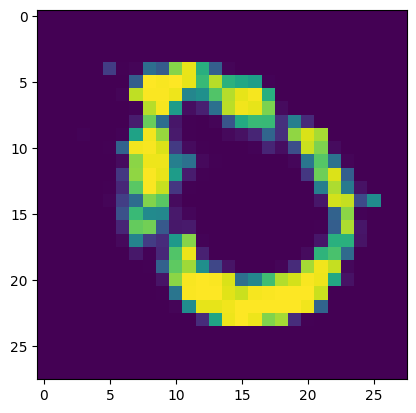

In [426]:
noise = (torch.rand(1, 128)[0])
fake = G_model(noise)
plt.imshow(fake.cpu().detach().numpy().reshape(28,28))

In [437]:
#save model
torch.save(G_model.state_dict(), 'generator_model')

In [438]:
#load model
model = Generator(128)
model.load_state_dict(torch.load('generator_model'))
model.eval()

Generator(
  (l1): Linear(in_features=128, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=784, bias=True)
  (act): ReLU()
)